# art contest leaderboard scrape

## setup

In [1]:
from bs4 import BeautifulSoup
import requests
import re

import pandas as pd
import numpy as np
import time

import altair as alt
from IPython.display import display

## `ArtContestScraper`

In [2]:
class ArtContestScraper:
    def __init__(self):
        # attributes
        self.submissions_url = lambda page: f'https://nouveaulabelcontest.com/submissions/page/{page}/'
        self.data_dict_list = []
        
    
    def randomly_sleep(self):
        time.sleep(np.random.randint(0, 10))
    
    def create_entry_list(self, soup):
        entry_list = list(set([
            item for sublist in
            [
                item.find_all_previous(
                    'a', 
                    href=re.compile(r'https://nouveaulabelcontest.com/[a-z-0-9]+/#(comments|respond)')
                )
                for item in soup.find_all('a', attrs={'class':'more-link style2-button'})
            ]
            for item in sublist
        ]))
        
        entry_list.sort(key=lambda x: str(x)) 
        #print(f'entry list entry count: {len(entry_list)}')
        
        return entry_list
    
    def create_data_dict(self, soup):
        # get entry list
        entry_list = self.create_entry_list(soup)
        
        # build data dict
        data_dict = {
            # key
            re.findall(
                r'https://nouveaulabelcontest.com/([a-z-0-9]+)/',
                entry.attrs['href']
            )[0]: {
                
                # metadata subdict        
                'link': re.findall(
                    r'https://nouveaulabelcontest.com/[a-z-0-9]+/',
                    entry.attrs['href']
                )[0],
                
                'comments': re.findall(
                    r'(\d+)\s+comments', 
                    entry.get_text()
                )[0],
                
                'artist': '',
                'title': ''
            }
            for entry in entry_list
        }
        
        #print(f'data dict entry count: {len(data_dict.keys())}')
        assert len(entry_list) == len(data_dict.keys()), 'entry count mismatch'
        
        return data_dict    
    
    def get_page_data(self, url):
        # get page
        r = requests.get(url)
        print(f'\tstatus: {r.status_code}')
        
        # soupify
        soup = BeautifulSoup(r.content, 'lxml')    
        
        # build data dict
        return self.create_data_dict(soup)
    
    
    def get_entry_details(self, data_dict, key, link):
        r = requests.get(link)
        #print(f'status: {r.status_code}')
    
        soup = BeautifulSoup(r.content, 'lxml')
        
        # get entry metadata
        entry_meta = soup.find_all('h4')
        
        # store in data dict
        try:
            data_dict[key]['artist'] = re.findall(r'Artist: ([A-Za-z ]+)', entry_meta[0].get_text())[0]
        except IndexError:
            data_dict[key]['artist'] = 'not found'
            
        try:
            data_dict[key]['title'] = re.findall(r'Title: ([A-Za-z ]+)', entry_meta[1].get_text())[0]
        except IndexError:
            data_dict[key]['title'] = 'not found'
                
        return data_dict
    
    def get_all_entry_details(self, data_dict):
        for key, subdict in data_dict.items():
            self.randomly_sleep()
            #print(f'getting details for {key}')
            
            data_dict = self.get_entry_details(data_dict, key, subdict['link'])
        
        print(f'\tgot entry details for {len(data_dict.keys())} items')
        return data_dict
    
    def page_has_data(self, url):
        r = requests.get(url)
        soup = BeautifulSoup(r.content, 'lxml')
        
        if len(soup.find_all('a', attrs={'class':'more-link style2-button'})) > 0:
            return True
        return False
    
    def process_data_dict_list(self):
        # convert to records
        data_records = [
            {
                'key': key,
                'link': subdict['link'],
                'title': subdict['title'],
                'artist': subdict['artist'],
                'comments': subdict['comments']
            }
            for data in self.data_dict_list
            for key, subdict in data.items()    
        ]
        
        # load dataframe
        self.alt_df = (
            pd
            .DataFrame(data_records)
            .assign(
                # set dtype
                comments = lambda x: x.comments.astype('int'),
                
                # mark target
                dummy = lambda x: [
                    'deep-green' 
                        if artist == 'Reuf Kapetanovic'
                        else 'other'
                    for artist in x.artist
                ],
                
                # fill titles
                title = lambda x: [
                    key
                        if title == 'not found'
                        else title
                    for key, title in zip(x.key, x.title)
                ]
            )
        )
        print(f'created dataframe, {self.alt_df.shape[0]} entries')
        
    
    def generate_leaderboard_chart(self):
        # explicit sort list
        sort_list = list(
            self
            .alt_df
            .query('comments > 0')
            .sort_values('comments', ascending=False)
            .key
            .values
        )
        
        # chart
        self.rank_chart = alt.Chart(
            self.alt_df.query('comments > 0')
        ).mark_bar(
        ).encode(
            alt.Y(
                'key:N',
                sort=sort_list
            ),
            alt.X(
                'comments:Q',
                axis=alt.Axis(orient='top')
            ),
            color='dummy:N',
            href='link',
            tooltip=[
                alt.Tooltip('artist:N'),
                alt.Tooltip('title:N'),
                alt.Tooltip('comments:Q')
            ]
        ).properties(
            title='comment count by submission'
        ).configure(
            #background='#abb2bf'
        )
        
        display(self.rank_chart)
        try:
            self.rank_chart.save('rank-chart.png')
        except Exception as e:
            print(f'exception encountered: {e}')
    
    def main(self):
        i = 1
        start_time = time.time()
        
        while True:
            if self.page_has_data(self.submissions_url(i)):
                self.randomly_sleep()
                print(f'getting page {i}')
        
                # get all details
                data_dict = self.get_all_entry_details(
                    self.get_page_data(
                        self.submissions_url(i)
                    )
                )
                
                self.data_dict_list.append(data_dict)                
                i += 1
            
            else:
                print(f'scrape complete, elapsed time: {(time.time() - start_time)/60:0.1f} minutes')
                break
        
        self.process_data_dict_list()
        self.generate_leaderboard_chart()

        

In [ ]:
ACS = ArtContestScraper()
ACS.main()

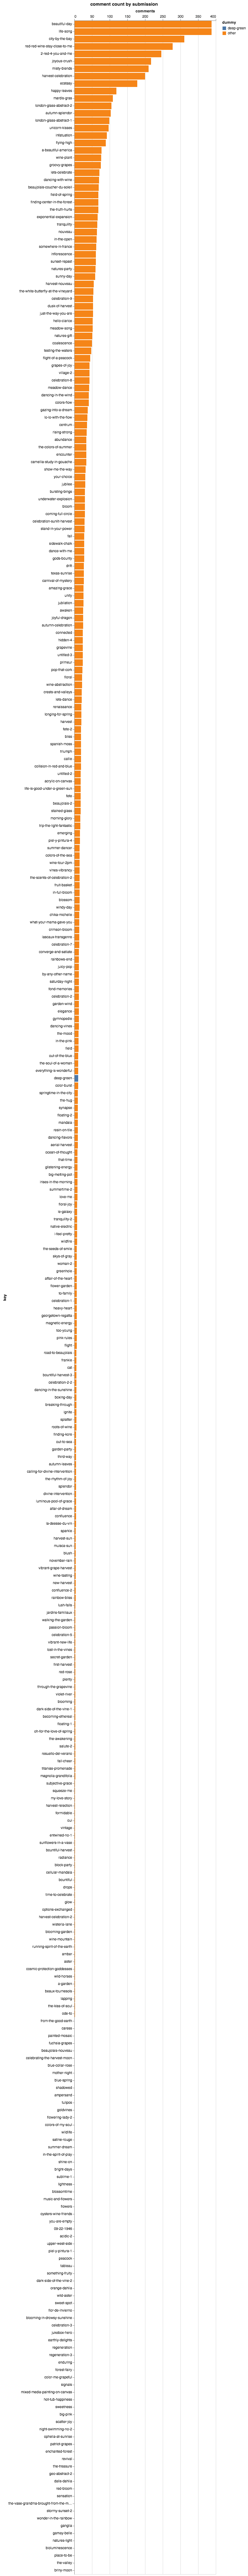

exception encountered: Message: 'chromedriver' executable needs to be in PATH. Please see https://sites.google.com/a/chromium.org/chromedriver/home



In [5]:
ACS.generate_leaderboard_chart()

In [4]:
ACS.alt_df.head()

,artist,comments,key,link,title,dummy
0,Valerie Yoder,3,first-harvest,https://nouveaulabelcontest.com/first-harvest/,First Harvest,other
1,Samantha Lee,13,gymnopedie,https://nouveaulabelcontest.com/gymnopedie/,Gymnopedie,other
2,Samantha Lee,3,resuello-del-verano,https://nouveaulabelcontest.com/resuello-del-v...,Resuello Del Verano,other
3,Eve Ozer,0,self-as-plural-2,https://nouveaulabelcontest.com/self-as-plural-2/,Self As Plural,other
4,Rina Kazavchinski,27,texas-sunrise,https://nouveaulabelcontest.com/texas-sunrise/,Texas Sunrise,other


In [ ]:
alt_df =  ACS.alt_df

%store alt_df